## Import Libraries

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

## Read Dataset

In [249]:
df  = pd.read_csv('GoldPrice_13-23.csv')
df[:5]

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


## Preprocess Dataset

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


All dtype of columns are object, we have to convert to datetime and float

In [251]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df['Price'] = df['Price'].replace({',': ''}, regex = True).astype('float64')

Because using Window sliding for Time-series regression. Keep Date and Price is enough,and that's the reason why I just convert dtype for those columns

In [252]:
df = df.drop(columns=['Vol.', 'Change %', 'Open', 'High', 'Low'])

In [253]:
df

,Date,Price
0,2013-01-02,1689.9
1,2013-01-03,1675.6
2,2013-01-04,1649.9
3,2013-01-07,1647.2
4,2013-01-08,1663.2
...,...,...
2578,2022-12-26,1809.7
2579,2022-12-27,1823.1
2580,2022-12-28,1815.8
2581,2022-12-29,1826.0


Checking miss value

In [241]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [242]:
df.duplicated().sum()

np.int64(0)

## Data Visualization

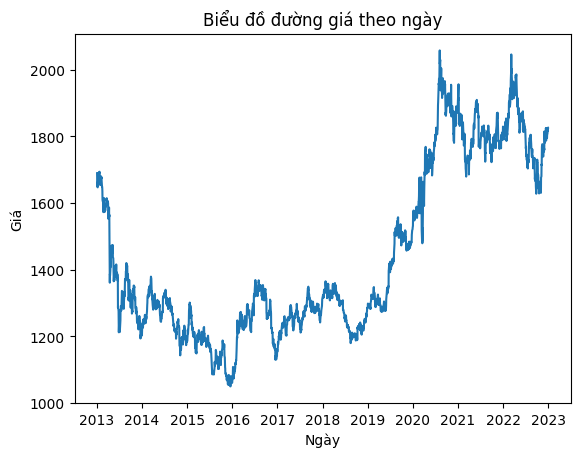

In [243]:
sns.lineplot(x=df['Date'], y=df['Price'])

plt.title('Biểu đồ đường giá theo ngày')
plt.xlabel('Ngày')
plt.ylabel('Giá')

plt.show()

## Split Data

In time-series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training

In [254]:
test_size = df[df['Date'].dt.year == 2022].shape[0]
test_size

260

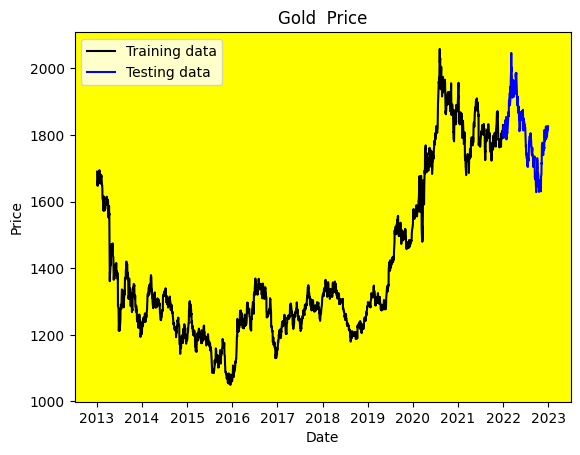

In [255]:
sns.lineplot(x=df['Date'][:-test_size], y=df['Price'][:-test_size], color =  'black', label = 'Training data')
sns.lineplot(x=df['Date'][-test_size:], y=df['Price'][-test_size:], color =  'blue', label = 'Testing data')


plt.title('Gold  Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().set_facecolor('yellow')
plt.legend()
plt.show()

##  Data Scaling

In [256]:
scaler = MinMaxScaler()
scaler.fit(df['Price'].values.reshape(-1, 1))

MinMaxScaler()

The approach of using previous time steps to predict the next time step is known as the sliding window method. This technique transforms time series data into a supervised learning problem. We achieve this by treating past time steps as input variables and the subsequent time step as the output variable. The number of past time steps considered is referred to as the window width. In this case, we set the window width to 60. Consequently, X_train and X_test will be nested lists, where each inner list contains 60 consecutive time-step prices. Similarly, y_train and y_test are lists of gold prices, where each price corresponds to the next day's gold price relative to each list in X_train and X_test.

In [257]:
train_data = df['Price'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

X_train = []
y_train = []

win_size = 60

for i in range(win_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [258]:
test_data = df['Price'][-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

X_test = []
y_test= []

win_size = 60

for i in range(win_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [259]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Random Forest

In [260]:
model = RandomForestRegressor(
    random_state = 42,
    n_estimators = 200
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mAPE = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 1 - mAPE

float(accuracy)

0.9777429724500334

In [263]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
df['Price_Pred'] = 0
df['Price_Pred'][-test_size:] = y_pred.flatten()

/var/folders/1x/qvtwdhkd12x9_f978jnnp3l00000gn/T/ipykernel_29631/1398426564.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Price_Pred'][-test_size:] = y_pred.flatten()
/var/folders/1x/qvtwdhkd12x9_f978jnnp3l00000gn/T/ipykernel_29631

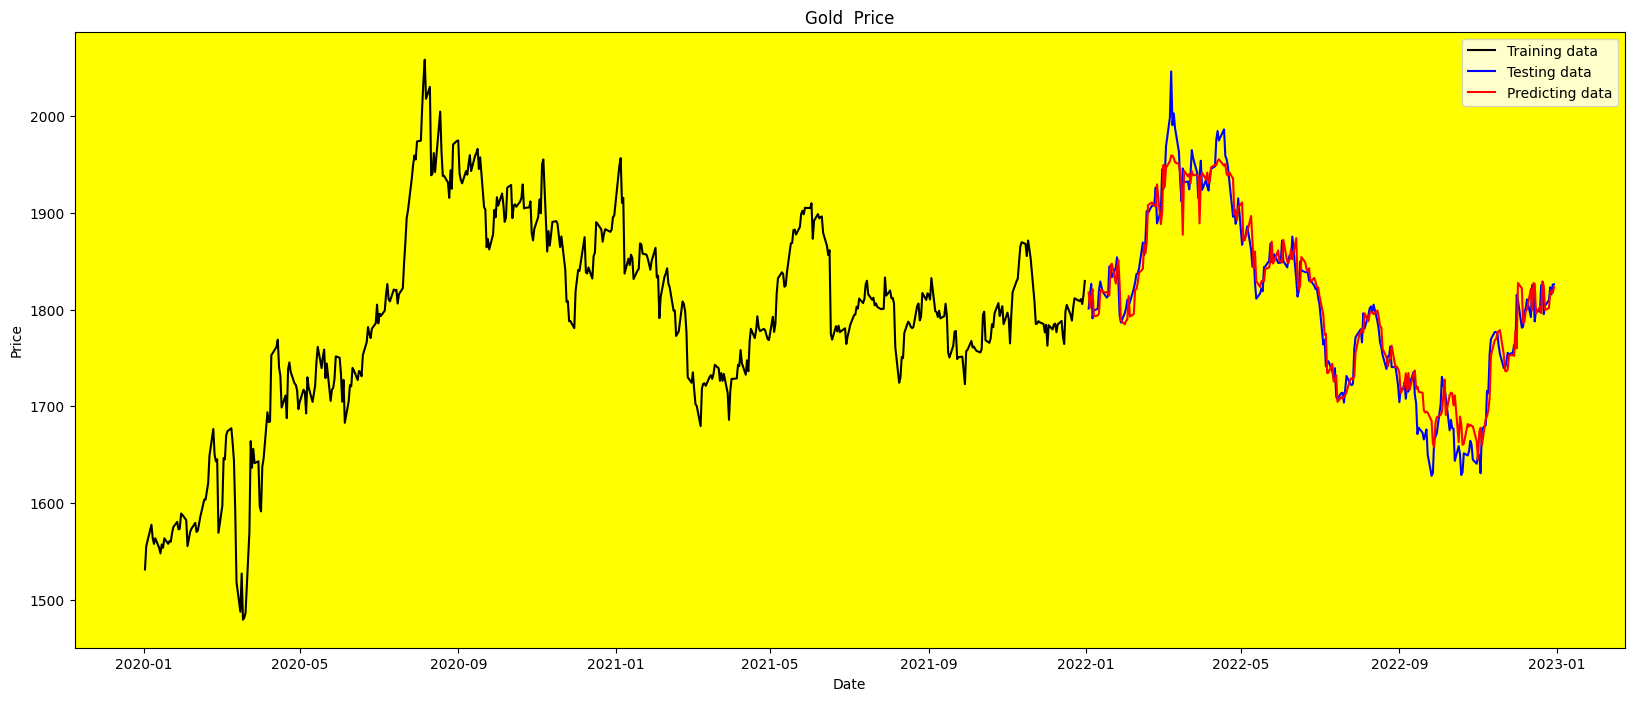

In [264]:
plt.figure(figsize=(20, 8))

sns.lineplot(x=df['Date'][df[df['Date'].dt.year < 2020].shape[0]:-test_size], y=df['Price'][:-test_size], color =  'black', label = 'Training data')
sns.lineplot(x=df['Date'][-test_size:], y=df['Price'][-test_size:], color =  'blue', label = 'Testing data')
sns.lineplot(x=df['Date'][-test_size:], y=df['Price_Pred'][-test_size:], color =  'red', label = 'Predicting data')


plt.title('Gold  Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().set_facecolor('yellow')
plt.legend()
plt.show()